# Оценка балла общей облачности (БОО, total cloud cover, TCC)

In [20]:
!pip3 install imgaug 
!pip3 install -U albumentations

     |████████████████████████████████| 81kB 1.4MB/s 
     |████████████████████████████████| 952kB 7.8MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [304]:
from IPython.core.display import display, HTML

import os
import time
import copy
import threading
import tarfile
import pickle
from queue import Queue, Empty
from shutil import rmtree
from tqdm import tqdm, trange
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pylab as plt 
%matplotlib inline
plt.style.use('ggplot')

from skimage.io import imshow, imread
from skimage.transform import resize

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torch.autograd import Variable
from torchvision import io

from imgaug.augmentables import Keypoint, KeypointsOnImage
import imgaug.augmenters as iaa

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from warnings import filterwarnings
filterwarnings('ignore', module="matplotlib\..*")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [4]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# для более быстрой обработки изображений
torchvision.set_image_backend('accimage')

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cuda device


# Загрузка данных

`./train_val` - директория с данными для тренировки и валидации 

`./test` - директория с данными для теста

In [6]:
!wget https://www.dropbox.com/s/nyy2q2zb1bkw3mi/train.tar.gz
!wget https://www.dropbox.com/s/a9k38jd1keuwnnv/test.tar.gz

--2021-05-17 21:26:37--  https://www.dropbox.com/s/nyy2q2zb1bkw3mi/train.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nyy2q2zb1bkw3mi/train.tar.gz [following]
--2021-05-17 21:26:38--  https://www.dropbox.com/s/raw/nyy2q2zb1bkw3mi/train.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc746e75a390e6623a88c70ae341.dl.dropboxusercontent.com/cd/0/inline/BOqPe39M-FtIOWUNm8j5mIi00-QYkWbHlWAUiHXi2lFsbwjfANcr8UX5zwqgsVH3gAybKl3VYeZZOVd5uvAfXbgeRewh7Rb3MhH3E3dPrAc8VTbQRcGSPjE_ln2L5sO2eBLlWBKuk0EEGaxaNBXnT2Bl/file# [following]
--2021-05-17 21:26:38--  https://uc746e75a390e6623a88c70ae341.dl.dropboxusercontent.com/cd/0/inline/BOqPe39M-FtIOWUNm8j5mIi00-QYkWbHlWAUiHXi2lFsbwjfANcr8UX5zwqgsVH3gAybKl3VYeZZOVd5uvAfXbgeRe

In [7]:
ROOT = './'

TRAIN_VAL_FILE = 'train.tar.gz'
TRAIN_VAL_ROOT = os.path.join(ROOT, 'train_val')

TEST_FILE = 'test.tar.gz'
TEST_ROOT = os.path.join(ROOT, 'test')

MODES = ('train', 'val', 'test')

RESIZE_SHAPE = (224, 224)

VAL_FRACTION = 0.9

CLASSES_NUM = 9

In [8]:
def download_data(file_name: str, dir_path: str):
    with tarfile.open(os.path.join(ROOT, file_name), 'r:gz') as tar:
        if os.path.isdir(dir_path):
            rmtree(dir_path)

        tar.extractall(path=dir_path)

    os.remove(os.path.join(ROOT, file_name))

In [9]:
download_data(file_name=TRAIN_VAL_FILE, dir_path=TRAIN_VAL_ROOT)
download_data(file_name=TEST_FILE, dir_path=TEST_ROOT)

In [10]:
with open('./train_val//index.pkl', 'rb') as f:
    train_val_index = pickle.load(f)

with open('./test/index.pkl', 'rb') as f:
    test_index = pickle.load(f)

train_val_df = pd.DataFrame(train_val_index)
test_df = pd.DataFrame(test_index)

In [11]:
train_val_df.shape, test_df.shape

((92077, 8), (27000, 5))

In [12]:
train_val_df.head()

,jpg_filename,lon,lat,mask_fname,mission,devID,observations_dt,observed_TCC
0,img-2019-12-11T10-02-37devID2.jpg,-10.783049,41.343315,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 10:00:00.000,4
1,img-2019-12-11T09-56-17devID2.jpg,-10.775720,41.359167,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 10:00:00.000,4
2,img-2019-12-11T10-04-17devID1.jpg,-10.784958,41.339135,AMK79/masks/mask-id1.png,AMK79,1,2019-12-11 10:00:00.000,4
3,img-2019-12-11T14-00-00devID2.jpg,-11.037792,40.761531,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 13:59:59.975,1
4,img-2019-12-11T12-58-20devID2.jpg,-10.973738,40.909492,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 12:59:59.980,1


In [13]:
test_df.head()

,jpg_filename,mask_fname,mission,devID,observations_dt
0,74c59e4b-6039-4310-bdd8-269da54d16cc.jpg,AI49/masks/mask-id2.png,AI49,2,2015-06-29 22:00:00.000
1,c1fd8fc6-d0a3-404b-b533-ea62b9a1b559.jpg,AMK71/masks/mask-id2.png,AMK71,2,2018-07-03 08:59:59.985
2,fa876324-8711-4713-801b-097d626c9cf3.jpg,AMK71/masks/mask-id2.png,AMK71,2,2018-07-24 08:08:00.000
3,404863be-8c7b-4aba-9a11-70e61099068e.jpg,AMK71/masks/mask-id1.png,AMK71,1,2018-07-05 20:59:59.925
4,fabbec27-45fe-435a-b3b7-717a6495bd56.jpg,AMK70/masks/mask-id1.png,AMK70,1,2017-10-09 14:00:00.030


## Создание "описаний" для данных

Так как последовательные данные в рамках одной экспедиции сильно скореллированы, то логичным будет сперва перемешать датасет, а лишь затем делить его на train и val. Для начала предлагаю попробовать разбить данные в пропорции 90% на 10%.

In [14]:
train_df, val_df = train_test_split(train_val_df, test_size=VAL_FRACTION, shuffle=True)
val_df.shape, train_df.shape

((82870, 8), (9207, 8))

In [15]:
train_df.head()

,jpg_filename,lon,lat,mask_fname,mission,devID,observations_dt,observed_TCC
57802,img-2016-10-24T12-55-02devID1.jpg,-33.955833,-27.044740,AI52/masks/mask-id1.png,AI52,1,2016-10-24 13:00:00,5
1230,img-2020-01-03T09-59-06devID1.jpg,-40.555248,-31.539307,AMK79/masks/mask-id1.png,AMK79,1,2020-01-03 10:00:00,8
67196,img-2016-10-14T14-59-01devID1.jpg,-22.078332,9.065798,AI52/masks/mask-id1.png,AI52,1,2016-10-14 15:00:06,5
71863,img-2016-10-23T16-57-22devID2.jpg,-33.509378,-26.012350,AI52/masks/mask-id2.png,AI52,2,2016-10-23 17:00:03,8
32779,img-2017-01-23T10-55-22devID2.jpg,94.055040,6.044073,ABP42/masks/mask-id2.png,ABP42,2,2017-01-23 11:00:00,8


In [16]:
val_df.head()

,jpg_filename,lon,lat,mask_fname,mission,devID,observations_dt,observed_TCC
47762,img-2017-02-22T08-00-22devID1.jpg,64.989378,1.527456,ABP42/masks/mask-id1.png,ABP42,1,2017-02-22 07:59:59.975,5
30329,img-2017-02-07T10-00-02devID2.jpg,83.299933,1.146790,ABP42/masks/mask-id2.png,ABP42,2,2017-02-07 10:00:00.040,2
78269,img-2016-10-30T10-04-35devID1.jpg,-47.575707,-40.959477,AI52/masks/mask-id1.png,AI52,1,2016-10-30 10:00:02.000,0
70949,img-2016-10-23T19-03-58devID1.jpg,-33.658907,-26.291334,AI52/masks/mask-id1.png,AI52,1,2016-10-23 19:00:00.000,8
33910,img-2017-02-27T11-59-24devID2.jpg,53.421122,14.296796,ABP42/masks/mask-id2.png,ABP42,2,2017-02-27 11:59:59.955,4


In [17]:
train_description = train_df[['jpg_filename', 'mask_fname', 'mission','observations_dt', 'observed_TCC']]
train_description['observations_dt'] = train_description['observations_dt'].apply(lambda x: x.date())
train_description.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,jpg_filename,mask_fname,mission,observations_dt,observed_TCC
57802,img-2016-10-24T12-55-02devID1.jpg,AI52/masks/mask-id1.png,AI52,2016-10-24,5
1230,img-2020-01-03T09-59-06devID1.jpg,AMK79/masks/mask-id1.png,AMK79,2020-01-03,8
67196,img-2016-10-14T14-59-01devID1.jpg,AI52/masks/mask-id1.png,AI52,2016-10-14,5
71863,img-2016-10-23T16-57-22devID2.jpg,AI52/masks/mask-id2.png,AI52,2016-10-23,8
32779,img-2017-01-23T10-55-22devID2.jpg,ABP42/masks/mask-id2.png,ABP42,2017-01-23,8


In [18]:
val_description = val_df[['jpg_filename', 'mask_fname', 'mission','observations_dt', 'observed_TCC']]
val_description['observations_dt'] = val_description['observations_dt'].apply(lambda x: x.date())
val_description.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,jpg_filename,mask_fname,mission,observations_dt,observed_TCC
47762,img-2017-02-22T08-00-22devID1.jpg,ABP42/masks/mask-id1.png,ABP42,2017-02-22,5
30329,img-2017-02-07T10-00-02devID2.jpg,ABP42/masks/mask-id2.png,ABP42,2017-02-07,2
78269,img-2016-10-30T10-04-35devID1.jpg,AI52/masks/mask-id1.png,AI52,2016-10-30,0
70949,img-2016-10-23T19-03-58devID1.jpg,AI52/masks/mask-id1.png,AI52,2016-10-23,8
33910,img-2017-02-27T11-59-24devID2.jpg,ABP42/masks/mask-id2.png,ABP42,2017-02-27,4


In [19]:
test_description = test_df[['jpg_filename', 'mask_fname', 'mission','observations_dt']]
test_description['observations_dt'] = test_description['observations_dt'].apply(lambda x: x.date())
test_description.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,jpg_filename,mask_fname,mission,observations_dt
0,74c59e4b-6039-4310-bdd8-269da54d16cc.jpg,AI49/masks/mask-id2.png,AI49,2015-06-29
1,c1fd8fc6-d0a3-404b-b533-ea62b9a1b559.jpg,AMK71/masks/mask-id2.png,AMK71,2018-07-03
2,fa876324-8711-4713-801b-097d626c9cf3.jpg,AMK71/masks/mask-id2.png,AMK71,2018-07-24
3,404863be-8c7b-4aba-9a11-70e61099068e.jpg,AMK71/masks/mask-id1.png,AMK71,2018-07-05
4,fabbec27-45fe-435a-b3b7-717a6495bd56.jpg,AMK70/masks/mask-id1.png,AMK70,2017-10-09


## Определение аугментаций данных

In [146]:
train_val_transforms = A.Compose(
    [
     A.Resize(height=RESIZE_SHAPE[0], width=RESIZE_SHAPE[1]),
     A.Flip(),
     A.Rotate(limit=20),
     A.ChannelShuffle(),
     A.CoarseDropout(),
     ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
     A.Resize(height=RESIZE_SHAPE[0], width=RESIZE_SHAPE[1]),
     ToTensorV2(),
    ]
)

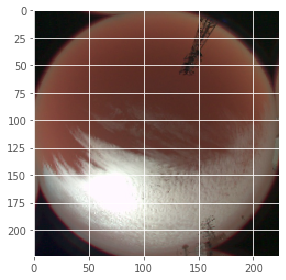

In [145]:
img = imread('/content/train_val/AI52/snapshots/snapshots-2016-10-05/img-2016-10-05T11-56-08devID1.jpg')
aug = train_val_transforms(image=img)['image']
aug = np.moveaxis(aug.numpy(), 0, -1)
imshow(aug)

## Многопоточный Dataset (требует доработки, лучше использовать пока что SimpleDataset)

In [48]:
class ThreadKiller:    
    """Boolean object for signaling a worker thread to terminate
    Once a thread is launched, it should be terminated at some moment.
    In case the function of this thread is an infinite loop, one needs a mutex
    for signaling a worker thread to break the loop.
    The fuction will return, and the thread will be terminated.
    """
    
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill

In [ ]:
def threaded_batches_feeder(tokill, batches_queue, dataset_generator):
    """
    Threaded worker for pre-processing input data.
    tokill (thread_killer): an object that indicates whether a thread should be terminated
    dataset_generator (Dataset): training/validation data generator
    batches_queue (Queue): a limited size thread-safe Queue instance for train/validation data batches
    """
    while tokill() == False:
        for sample_batch in dataset_generator:
            batches_queue.put(torch.Tensor(sample_batch), block=True)
            if tokill() == True:
                return

In [ ]:
def threaded_cuda_batches(tokill, cuda_batches_queue, batches_queue):
    """
    Thread worker for transferring pytorch tensors into GPU. 
    batches_queue (Queue): the queue that fetches numpy cpu tensors.
    cuda_batches_queue (Queue): the queue receiving numpy cpu tensors and transfering them to GPU memory.
    """
    while tokill() == False:
        sample_batch = batches_queue.get(block=True)
        sample_batch = Variable(sample_batch).to(device)
        cuda_batches_queue.put(sample_batch, block=True)
        if tokill() == True:
            return

In [ ]:
class ThreadsafeIter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def get_objects_i(objects_count):
    """Cyclic generator of paths indices"""
    current_objects_id = 0
    while True:
        yield current_objects_id
        current_objects_id  = (current_objects_id + 1) % objects_count

In [ ]:
class NonExistentMode(Exception):
    def __init__(self):
        super().__init__(self)


class MultiThreadDataset(Dataset):
    def __init__(self, description, root_dir, mode, apply_mask=True, augment=None, batch_size=8):
        self.description = description
        self.root_dir = root_dir
        self.length = description.shape[0]
        self.batch_size = batch_size
        self.augment = augment
        self.objects_id_generator = ThreadsafeIter(get_objects_i(self.length))
        self.lock = threading.Lock()
        self.yield_lock = threading.Lock()
        self.init_count = 0
        self.cache = {}
        self.apply_mask = apply_mask

        if mode in MODES:
            self.mode = mode
        else:
            raise NonExistendMode(mode)
        
        if self.augment is not None:
            self.seq = self.augment
        else:
            self.seq = iaa.Identity()       


    def __len__(self):                        
        return self.length
        
    def __iter__(self):
        while True:
            with self.lock:
                if self.init_count == 0:
                    self.imgs = []
                    self.init_count = 1
            
            for obj_id in self.objects_id_generator:
                # DOWNLOADING IMAGE
                sub_dir = 'snapshots-' + str(self.description.iloc[obj_id, 3])
                img_path =  os.path.join(self.root_dir, self.description.iloc[obj_id, 2], 'snapshots', sub_dir, self.description.iloc[obj_id, 0])
                if img_path in self.cache:
                    img = self.cache[img_path]
                    img_np = np.moveaxis(img.numpy(), 0, -1)  # HxWxC
                else:
                    img = io.read_image(img_path)  # stands for accimage (i hope) (CxHxW)
                    self.cache[img_path] = img
                    img_np = np.moveaxis(img.numpy(), 0, -1)  # HxWxC

                # APPLYING MASK
                if self.apply_mask:
                    mask_path = os.path.join(self.root_dir, self.description.iloc[obj_id, 1])
                    mask = io.read_image(mask_path)  # HxW

                    if mask.shape[0] != img.shape[1] or mask.shape[1] != img.shape[2]:
                        mask = resize(image=mask, output_shape=img.shape[1:])

                    img_np = img_np * mask[:, :, np.newaxis]  # finally add mask
        
                    img_np = img_np.astype(np.uint8)
                    
                    img = np.moveaxis(img_np, 0, -1)
                    assert img.shape[0] == 3
                    img = torch.from_numpy(img)
                

                img = self.augment(image)

                if self.mode == 'train':
                    self.imgs.append(img)
                
                else:
                    label = self.description.iloc[obj_id, -1]
                    self.imgs.append((img, label))


                if len(self.imgs) == batch_size:
                    break
            
            with self.yield_lock:
                yield self.imgs
                    
                     
            # At the end of an epoch we re-init data-structures
            with self.lock:
                self.landmarks_frame = shuffle(self.landmarks_frame)
                self.init_count = 0

## Простой Dataset (рекомедную использовать его)

In [285]:
class SimpleDataset(Dataset):
    def __init__(self, description, root_dir, mode, apply_mask=True, augment=None):
        self.description = description
        self.root_dir = root_dir
        self.apply_mask = apply_mask
        self.augment = augment

        self.length = self.description.shape[0]

        if mode in MODES:
            self.mode = mode
        else:
            raise NonExistendMode(mode)
        
        if self.augment is not None:
            self.seq = self.augment
        else:
            self.seq = iaa.Identity()

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if self.description.iloc[index, 2] == 'AI49':  # special case (very unusual!!!)
            sub_dir = 'ai49-snapshots-' + str(self.description.iloc[index, 3])
        else:
            sub_dir = 'snapshots-' + str(self.description.iloc[index, 3])	

        img_path =  os.path.join(self.root_dir, self.description.iloc[index, 2], 'snapshots', sub_dir, self.description.iloc[index, 0])
        img = io.read_image(img_path)  # stands for accimage (i hope) (CxHxW)
        img_np = np.moveaxis(img.numpy(), source=(0, 1, 2), destination=(2, 0, 1))  # HxWxC

        # APPLYING MASK
#        if self.apply_mask:
#
#            mask_path = os.path.join(self.root_dir, self.description.iloc[index, 1])
#            mask = io.read_image(mask_path)  # CxHxW
#            mask_np = np.array(mask.squeeze()) # HxW
#           
#            if mask_np.shape[0] != img.shape[1] or mask_np.shape[1] != img.shape[2]:
#                mask_np = cv2.resize(mask_np, dsize=(img.shape[1], img.shape[2]))
#
#            img_np = img_np * mask_np[:, :, np.newaxis]  # finally add mask
#    
#            

        # APPLYING AUGMENTATATION
        img = self.seq(image=img_np)['image']
    
        if self.mode == 'test':
            return img  # same as (X)

        else:  # self.mode == train or self.mode == val
            label = self.description.iloc[index, -1]
            
            return img, label  # same as (X, y)


## Инициализация dataset'ов

In [286]:
train_dataset = SimpleDataset(
    description=train_description,
    root_dir=TRAIN_VAL_ROOT,
    mode='train',
    apply_mask=True,
    augment=train_val_transforms,
)

val_dataset = SimpleDataset(
    description=val_description,
    root_dir=TRAIN_VAL_ROOT,
    mode='val',
    apply_mask=True,
    augment=train_val_transforms,
)

test_dataset = SimpleDataset(
    description=test_description,
    root_dir=TEST_ROOT,
    mode='test',
    apply_mask=True,
    augment=test_transforms,
)

## Инициализация dataloader'ов

In [287]:
img = test_dataset[1]

In [288]:
img.shape

torch.Size([3, 224, 224])

In [289]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

learning_dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Проверка данных

In [290]:
def tensor2numpy(tensor):
    img = tensor.numpy()
    img = np.moveaxis(img, source=(0, 1, 2), destination=(2, 0, 1))

    return img

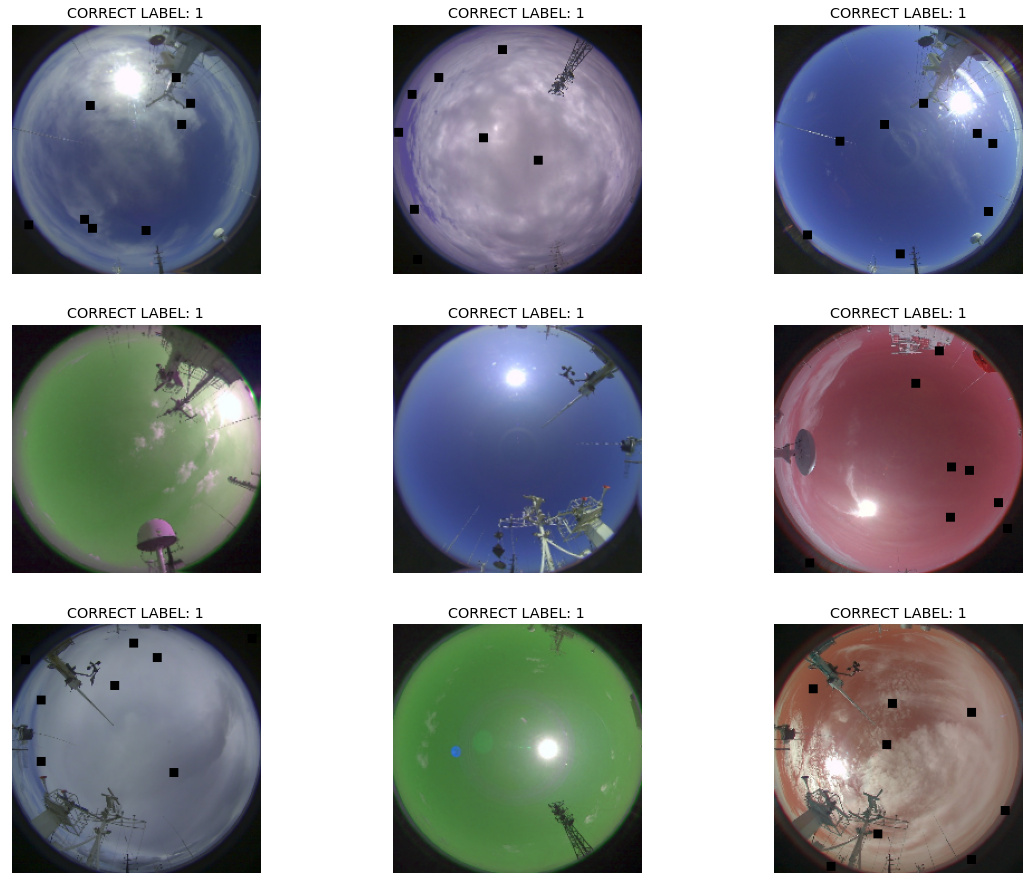

In [293]:
NUM = 3
fig, ax = plt.subplots(NUM, NUM, figsize=(10, 10))
plt.subplots_adjust(left=NUM*(-0.2), bottom=NUM*(-0.1))

for i in range(NUM**2):
    idx = np.random.randint(low=0, high=len(train_dataset))
    img, label = train_dataset[idx]
    img = np.moveaxis(img.numpy(), 0, -1)

    
    ax[i // NUM, i % NUM].imshow(img)
    ax[i // NUM, i % NUM].set_title(f'CORRECT LABEL: {1}')
    ax[i // NUM, i % NUM].set_xticks([])
    ax[i // NUM, i % NUM].set_yticks([])
    ax[i // NUM, i % NUM].grid(False);

# Тренировка модели

In [306]:
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, max_epochs=15):
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    running_accuracy = 0
    running_loss = 0

    best_model_wts = model.state_dict()
    best_accuracy = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
        val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=max_epochs) as pbar:
        
        for epoch in range(max_epochs):
            for data_mode in ('train', 'val'):
                if data_mode == 'train':
                    model.train()
                else:
                    model.eval()
                
                data_size = 0
                running_accuracy = 0
                running_loss = 0
                
                for X, y in tqdm(dataloaders[data_mode]):
                    # uniform device
                    X = X.to(DEVICE).float()
                    y = y.to(DEVICE)

                    optimizer.zero_grad()

                    if data_mode == 'train':
                        logits = model(X)

                        loss = criterion(logits, y)
                        loss.backward()

                        optimizer.step()

                        preds = torch.argmax(logits, dim=1)

                        running_accuracy += torch.sum((preds == y.data)).item()
                        running_loss += loss.item() * X.size(0)
                        data_size += X.size(0)
                

                    else:  # data_mode == 'val'
                        with torch.no_grad():
                            logits = model(X)

                            loss = criterion(logits, y)

                            preds = torch.argmax(logits, 1)

                            running_accuracy += torch.sum((preds == y.data)).item()
                            running_loss += loss.item() * X.size(0)
                            data_size += X.size(0)

                epoch_accuracy = running_accuracy / data_size
                accuracies[data_mode].append(epoch_accuracy)

                epoch_loss = running_loss / data_size
                losses[data_mode].append(epoch_loss)
        
            if data_mode == 'train':
                lr_scheduler.step()

            # сохраняем лучшую модель 
            if data_mode == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy 
                print('Saving best model...')
                best_model_wts = copy.deepcopy(model.state_dict())

            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=losses['train'][-1],\
                    v_loss=losses['val'][-1], t_acc=accuracies['train'][-1], v_acc=accuracies['val'][-1]))

    
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [327]:
def predict(model, test_loader):
    model.eval()
    
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE).float()
            outputs = model(inputs).cpu()
            logits.append(torch.argmax(outputs, 1))
            
    probs = torch.cat(logits).numpy()
    return probs 

In [308]:
def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        if feature_extracting:
            param.requires_grad = False
        
        else:
            param.requires_grad = True

# Тестирование моделек

## ResNet50

In [309]:
ResNet50 = models.resnet50(pretrained=True)

In [310]:
set_parameter_requires_grad(ResNet50, feature_extracting=False)

In [311]:
ResNet50.fc = nn.Linear(in_features=ResNet50.fc.in_features, out_features=CLASSES_NUM)

In [312]:
ResNet50 = ResNet50.to(DEVICE)

In [313]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    [
    {'params': ResNet50.layer1.parameters()},
    {'params': ResNet50.layer2.parameters()},
    {'params': ResNet50.layer3.parameters(), 'lr': 1e-5},
    {'params': ResNet50.layer4.parameters(), 'lr': 1e-4},
    {'params': ResNet50.fc.parameters(), 'lr': 1e-3}
     ], lr=1e-6,
)


exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [314]:
ResNet50, ResNet50_losses, ResNet50_accuracies = train_model(ResNet50, learning_dataloaders, criterion, optimizer, exp_lr_scheduler, max_epochs=1)


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  1%|          | 1/144 [00:01<03:22,  1.41s/it]

  1%|▏         | 2/144 [00:02<02:57,  1.25s/it]

  2%|▏         | 3/144 [00:03<02:40,  1.13s/it]

  3%|▎         | 4/144 [00:04<02:27,  1.05s/it]

  3%|▎         | 5/144 [00:04<02:18,  1.00it/s]

  4%|▍         | 6/144 [00:05<02:11,  1.05it/s]

  5%|▍         | 7/144 [00:06<02:06,  1.08it/s]

  6%|▌         | 8/144 [00:07<02:03,  1.10it/s]

  6%|▋         | 9/144 [00:08<02:00,  1.12it/s]

  7%|▋         | 10/144 [00:09<01:58,  1.13it/s]

  8%|▊         | 11/144 [00:10<01:56,  1.14it/s]

  8%|▊         | 12/144 [00:10<01:54,  1.15it/s]

  9%|▉         | 13/144 [00:11<01:53,  1.15it/s]

 10%|▉         | 14/144 [00:12<01:52,  1.15it/s]

 10%|█         | 15/144 [00:13<01:51,  1.15it/s]

 11%|█         | 16/144 [00:14<01:50,  1.16it/s]

 12%|█▏        | 17/144 [00:15<01:49,  1.16it/s]

 12%|█▎        | 18/144 [00:16<01:48,  1.16it/s]

 13%|█▎        | 19/1

Saving best model...

Epoch 001 train_loss: 1.1093         val_loss 0.8793 train_acc 0.5646 val_acc 0.6496


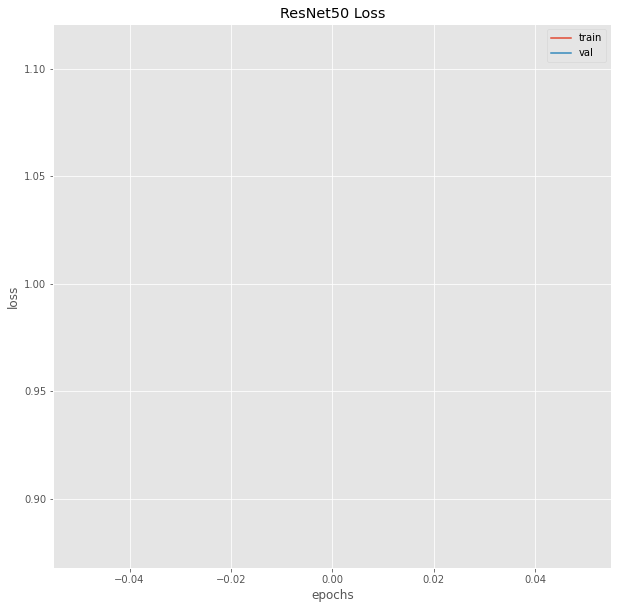

In [315]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ResNet50_losses['train'], label='train')
ax.plot(ResNet50_losses['val'], label='val')
ax.set_title('ResNet50 Loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.legend();

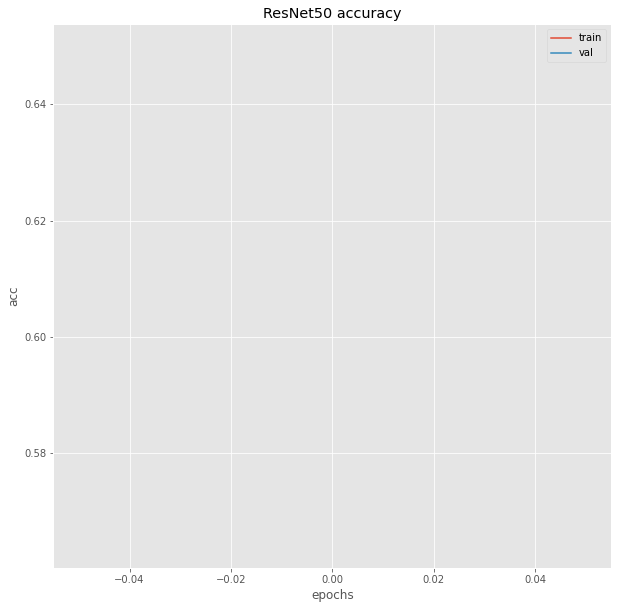

In [316]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ResNet50_accuracies['train'], label='train')
ax.plot(ResNet50_accuracies['val'], label='val')
ax.set_title('ResNet50 accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('acc')
plt.legend();

# Отправка на Kaggle

In [318]:
test_description.head()

,jpg_filename,mask_fname,mission,observations_dt
0,74c59e4b-6039-4310-bdd8-269da54d16cc.jpg,AI49/masks/mask-id2.png,AI49,2015-06-29
1,c1fd8fc6-d0a3-404b-b533-ea62b9a1b559.jpg,AMK71/masks/mask-id2.png,AMK71,2018-07-03
2,fa876324-8711-4713-801b-097d626c9cf3.jpg,AMK71/masks/mask-id2.png,AMK71,2018-07-24
3,404863be-8c7b-4aba-9a11-70e61099068e.jpg,AMK71/masks/mask-id1.png,AMK71,2018-07-05
4,fabbec27-45fe-435a-b3b7-717a6495bd56.jpg,AMK70/masks/mask-id1.png,AMK70,2017-10-09


In [328]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

preds = predict(ResNet50, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [329]:
test_filenames = test_description['jpg_filename']

In [330]:
submit = pd.DataFrame({'jpg_filename': test_filenames, 'TCC': preds})
submit.head()

,jpg_filename,TCC
0,74c59e4b-6039-4310-bdd8-269da54d16cc.jpg,0
1,c1fd8fc6-d0a3-404b-b533-ea62b9a1b559.jpg,8
2,fa876324-8711-4713-801b-097d626c9cf3.jpg,2
3,404863be-8c7b-4aba-9a11-70e61099068e.jpg,8
4,fabbec27-45fe-435a-b3b7-717a6495bd56.jpg,7


In [331]:
 submit.to_csv('solution.csv', index=False)